In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import autocast, GradScaler
from torch.utils.data import DataLoader
from torchvision import models, transforms
from sklearn.metrics import precision_score, recall_score, f1_score
import time
import numpy as np
print("CNN imports ready")


CNN imports ready


In [2]:
class SatelliteCNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        # Feature extractor (similar to VGG style)
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 224x224 -> 112x112
            
            # Block 2  
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 112x112 -> 56x56
            
            # Block 3
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 56x56 -> 28x28
            
            # Block 4
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 28x28 -> 14x14
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((7, 7)),  # 14x14 -> 7x7
            nn.Flatten(),
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

print("SatelliteCNN defined (4 conv blocks + classifier)")


SatelliteCNN defined (4 conv blocks + classifier)


In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import numpy as np

# Parameters
path = "satellite_data/"  # Your RSI-CB256 path
batch_size = 32
height, width = 224, 224
val_split_ratio = 0.2

# CNN transforms (ImageNet normalization)
transform = transforms.Compose([
    transforms.Resize((height, width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load full dataset WITH transforms
full_dataset = datasets.ImageFolder(root=path, transform=transform)

# Train/validation split
val_size = int(len(full_dataset) * val_split_ratio)
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

print(f"Dataset ready: {len(train_dataset)} train, {len(val_dataset)} val images")
print(f"Classes: {full_dataset.classes}")


Dataset ready: 4505 train, 1126 val images
Classes: ['cloudy', 'desert', 'green_area', 'water']


In [4]:
# OPTIMIZED FOR SATELLITE IMAGES (reuse the existing train_dataset)
batch_size = 32  # CNNs handle larger batches
train_loader = DataLoader(
    train_dataset,  # existing RSI-CB256 dataset
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

print(f"DataLoader ready: {len(train_dataset)} images, {len(train_loader)} batches")


DataLoader ready: 4505 images, 141 batches


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model
model = SatelliteCNN(num_classes=4)
model.to(device)

# Same training setup as ViT
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.05)
scaler = GradScaler('cuda')

# Performance optimizations
torch.backends.cudnn.benchmark = True
print("CNN model + optimizer ready")


Using device: cuda
CNN model + optimizer ready


In [6]:
# Start total timer
total_start_time = time.time()

class TrainingHistory:
    def __init__(self):
        self.losses = [0.0]
        self.accuracies = [0.0]
        self.precisions = [0.0]
        self.recalls = [0.0]
        self.f1s = [0.0]
        self.durations = [0.0]

# default 20
epoch_count = 50

history = TrainingHistory()
width = len(str(epoch_count))

print(f"Epoch [{0:0{width}d}/{epoch_count}] "
      f"Loss: {0.0:.4f} Accuracy: {0.0:.4f} Precision: {0.0:.4f} "
      f"Recall: {0.0:.4f} F1-score: {0.0:.4f} "
      f"Epoch Time: {0.00:.2f} seconds")

# Training loop
for epoch in range(epoch_count):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Metrics (exact same format as ViT)
    epoch_loss = running_loss / len(train_loader)
    accuracy = (torch.tensor(all_preds) == torch.tensor(all_labels)).float().mean().item()
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    epoch_duration = time.time() - epoch_start_time

    history.losses.append(epoch_loss)
    history.accuracies.append(accuracy)
    history.precisions.append(precision)
    history.recalls.append(recall)
    history.f1s.append(f1)
    history.durations.append(epoch_duration)

    print(f"Epoch [{epoch+1:0{width}d}/{epoch_count}] "
          f"Loss: {epoch_loss:.4f} Accuracy: {accuracy:.4f} Precision: {precision:.4f} "
          f"Recall: {recall:.4f} F1-score: {f1:.4f} "
          f"Epoch Time: {epoch_duration:.2f} seconds")

total_duration = time.time() - total_start_time
print(f"Total Training Time: {total_duration:.2f} seconds")
print("CNN Training Complete!")


Epoch [00/50] Loss: 0.0000 Accuracy: 0.0000 Precision: 0.0000 Recall: 0.0000 F1-score: 0.0000 Epoch Time: 0.00 seconds
Epoch [01/50] Loss: 0.8169 Accuracy: 0.4901 Precision: 0.4855 Recall: 0.4901 F1-score: 0.4836 Epoch Time: 78.42 seconds
Epoch [02/50] Loss: 0.7139 Accuracy: 0.5332 Precision: 0.5294 Recall: 0.5332 F1-score: 0.4869 Epoch Time: 20.79 seconds
Epoch [03/50] Loss: 0.5045 Accuracy: 0.7030 Precision: 0.7046 Recall: 0.7030 F1-score: 0.7023 Epoch Time: 22.15 seconds
Epoch [04/50] Loss: 0.4728 Accuracy: 0.7267 Precision: 0.7275 Recall: 0.7267 F1-score: 0.7267 Epoch Time: 22.14 seconds
Epoch [05/50] Loss: 0.4144 Accuracy: 0.8102 Precision: 0.8102 Recall: 0.8102 F1-score: 0.8101 Epoch Time: 22.99 seconds
Epoch [06/50] Loss: 0.3540 Accuracy: 0.8533 Precision: 0.8533 Recall: 0.8533 F1-score: 0.8531 Epoch Time: 23.17 seconds
Epoch [07/50] Loss: 0.3063 Accuracy: 0.8717 Precision: 0.8719 Recall: 0.8717 F1-score: 0.8716 Epoch Time: 23.54 seconds
Epoch [08/50] Loss: 0.2980 Accuracy: 0.88

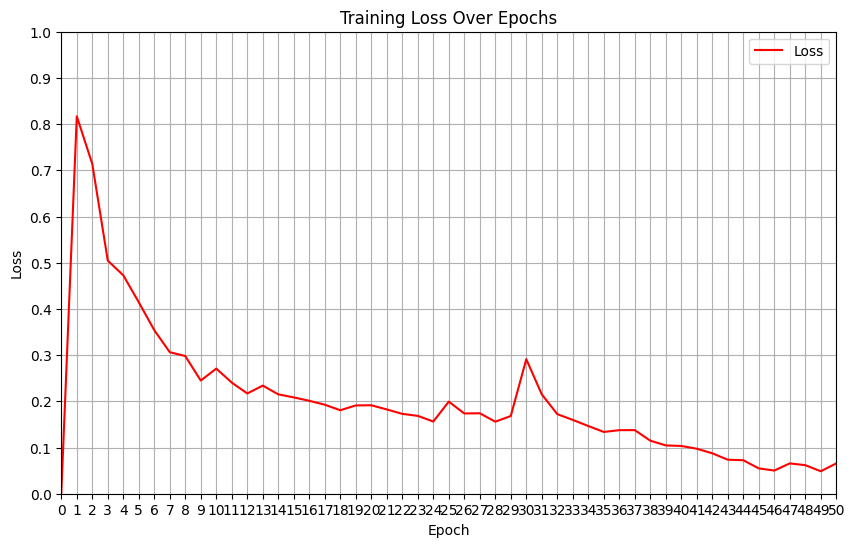

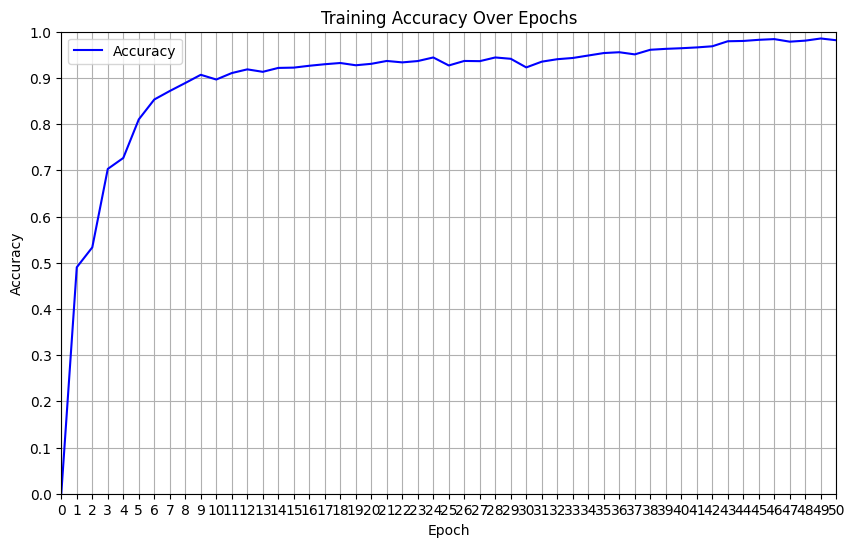

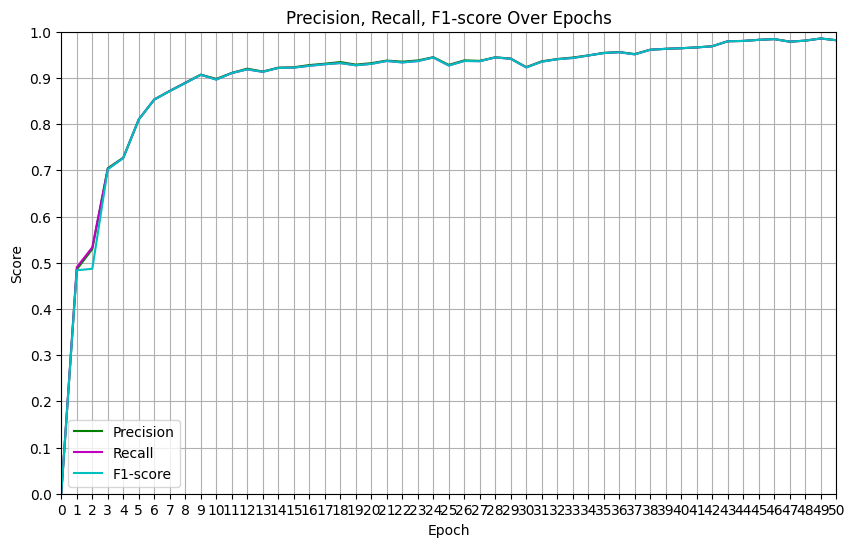

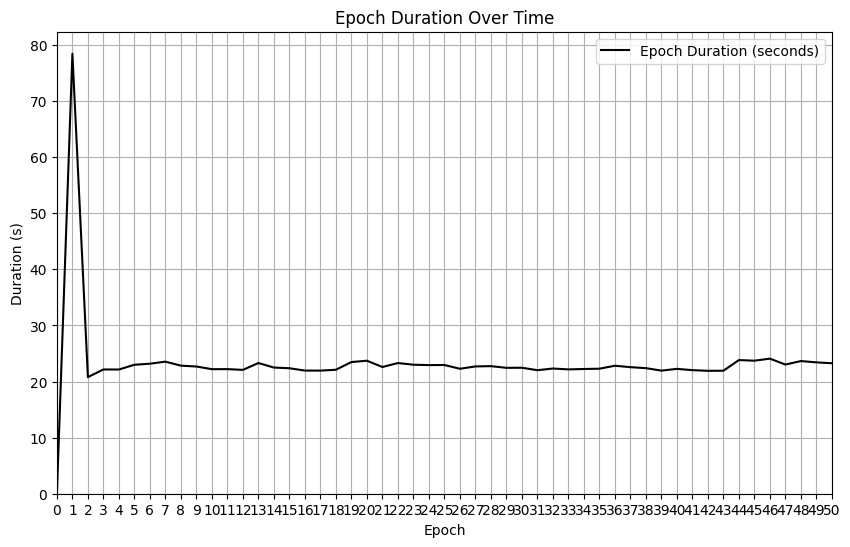

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


# use history (from the earlier model's training results) to compute graphs
epochs = range(0, len(history.losses))



# Plot Loss (Loss may not cap at 1.0 but for consistency, set max to 1.0)
plt.figure(figsize=(10, 6))
plt.plot(epochs, history.losses, 'r-', label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))  
plt.xlim(0, epoch_count)
plt.ylim(0, 1.0)  # y-axis max 1.0
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, history.accuracies, 'b-', label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.xlim(0, epoch_count)
plt.ylim(0, 1.0)
plt.show()

# Plot Precision, Recall, and F1-score together
plt.figure(figsize=(10, 6))
plt.plot(epochs, history.precisions, 'g-', label='Precision')
plt.plot(epochs, history.recalls, 'm-', label='Recall')
plt.plot(epochs, history.f1s, 'c-', label='F1-score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Precision, Recall, F1-score Over Epochs')
plt.legend()
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.xlim(0, epoch_count)
plt.ylim(0, 1.0)
plt.show()


# Plot Epoch Duration
plt.figure(figsize=(10, 6))
plt.plot(epochs, history.durations, 'k-', label='Epoch Duration (seconds)')
plt.xlabel('Epoch')
plt.ylabel('Duration (s)')
plt.title('Epoch Duration Over Time')
plt.legend()
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))  # set tick interval to 1
plt.xlim(0, epoch_count)
plt.ylim(bottom=0) # start y-axis at 0
plt.show()


In [8]:
from sklearn.metrics import confusion_matrix
import numpy as np

# After the epoch evaluation (after collecting all_preds and all_labels)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

print("Confusion Matrix:")
print(cm)


epoch_loss = running_loss / len(train_loader)
accuracy = (torch.tensor(all_preds) == torch.tensor(all_labels)).float().mean().item()
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

# New code for confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

print(f"Epoch [{epoch+1}/{epoch+1}] Loss: {epoch_loss:.4f} Accuracy: {accuracy:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1-score: {f1:.4f}")


Confusion Matrix:
[[1193   16    0    2]
 [  18  885    0    0]
 [   0    0 1181   18]
 [   8    0   21 1163]]
Confusion Matrix:
[[1193   16    0    2]
 [  18  885    0    0]
 [   0    0 1181   18]
 [   8    0   21 1163]]
Epoch [50/50] Loss: 0.0657 Accuracy: 0.9816 Precision: 0.9816 Recall: 0.9816 F1-score: 0.9816


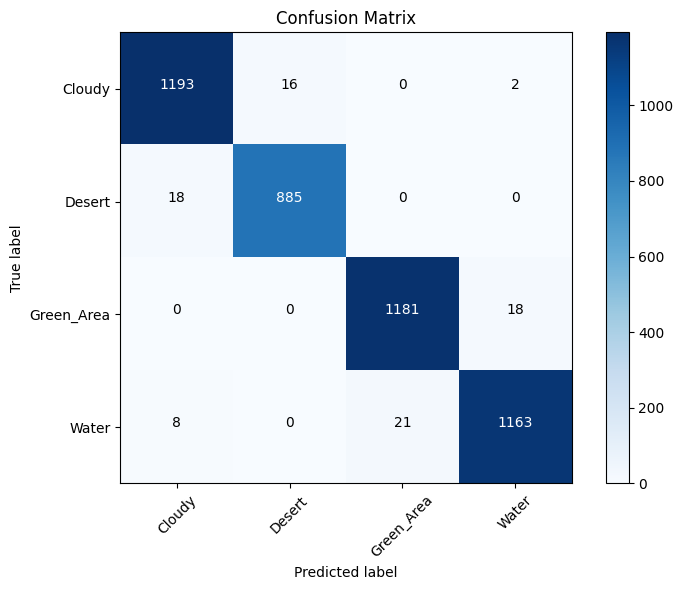

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming 'all_labels' and 'all_preds' contain true and predicted labels respectively
labels_names = ['Cloudy', 'Desert', 'Green_Area', 'Water']

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

# Labeling the axes with class names
num_classes = cm.shape[0]
plt.xticks(np.arange(num_classes), labels=labels_names, rotation=45)
plt.yticks(np.arange(num_classes), labels=labels_names)

# Axis labels
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Adding counts on the plot
thresh = cm.max() / 2
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


In [10]:
##### for testing purposes only

from PIL import Image
from collections import defaultdict
import os

# full_dataset is ImageFolder with transform=transform (might convert images, so ignore it here)

# Map from class index to class name
class_names = full_dataset.classes

# Store counts of resolutions per class
resolutions_per_class = {cls: defaultdict(int) for cls in class_names}

# Iterate over dataset samples (image paths are in dataset.imgs or dataset.samples)
for img_path, label in full_dataset.samples:
    with Image.open(img_path) as img:
        # Get image size (width, height)
        size = img.size
    class_name = class_names[label]
    # Increment count for this resolution for this class
    resolutions_per_class[class_name][size] += 1

# Print summary for each class
for cls, res_counts in resolutions_per_class.items():
    print(f"Class '{cls}':")
    for res, count in sorted(res_counts.items()):
        print(f"  Resolution {res[0]}x{res[1]} : {count} images")
    print()


Class 'cloudy':
  Resolution 256x256 : 1500 images

Class 'desert':
  Resolution 256x256 : 1131 images

Class 'green_area':
  Resolution 64x64 : 1500 images

Class 'water':
  Resolution 64x64 : 1500 images

